# SBU CSE 352 - HW 1.2 - Search: Solving a Maze Using a Goal-based Agent


---

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root node to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

Given:

*Deterministic --> the outsome of every action is predictable, no randomness.

*Discrete --> the number of possible states and actions is finite and countable.

*known --> the agents has a map of the maze.

*Open-loop --> we don't care about percepts.

S --> start location

G --> goal location

Using the map search for the path

In [4]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/Search
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2755, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 2755 (delta 4), reused 0 (delta 0), pack-reused 2740 (from 2)
Receiving objects: 100% (2755/2755), 252.36 MiB | 35.68 MiB/s, done.
Resolving deltas: 100% (1719/1719), done.
Updating files: 100% (135/135), done.
/content/CS7320-AI/Search
empty_2_maze.txt	  loops_maze.txt		     maze_helper.py   small_maze.txt
empty_maze.txt		  Maze_BFS_vs_A_Star.ipynb	     Maze.ipynb       wall_maze.txt
Explore_heuristics.ipynb  Maze_Example-Animation_full.ipynb  medium_maze.txt
large_maze.txt		  Maze_Example-Animation.ipynb	     open_maze.txt
L_maze.txt		  Maze_Example.ipynb		     README.md


In [3]:
with open("open_maze.txt", "r") as f2:
    maze_str2 = f2.read()
print(maze_str2)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
X                                  SX
X            X                      X
X            X                      X
X            X                      X
X            X                      X
X            X                      X
X            X      X               X
X            X      X               X
X            X      X               X
X            X      X               X
X            X      X               X
X            X      X               X
X            X      X               X
XXXXXXXXXXXXXX      XXXXXXXXXXXXXXXXX
X            X                      X
X            X                      X
X            X                      X
X                                   X
X                                   X
X                                   X
XG                                  X
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



In [2]:
# if the below fails to open, then small_maze.txt is not in the current working directory (see above code block)
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [30]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))
print(mh.find_pos(maze,'S'))

Position(0,0): X
Position(8,1): G
(3, 11)


A helper function to visualize the maze is also available.

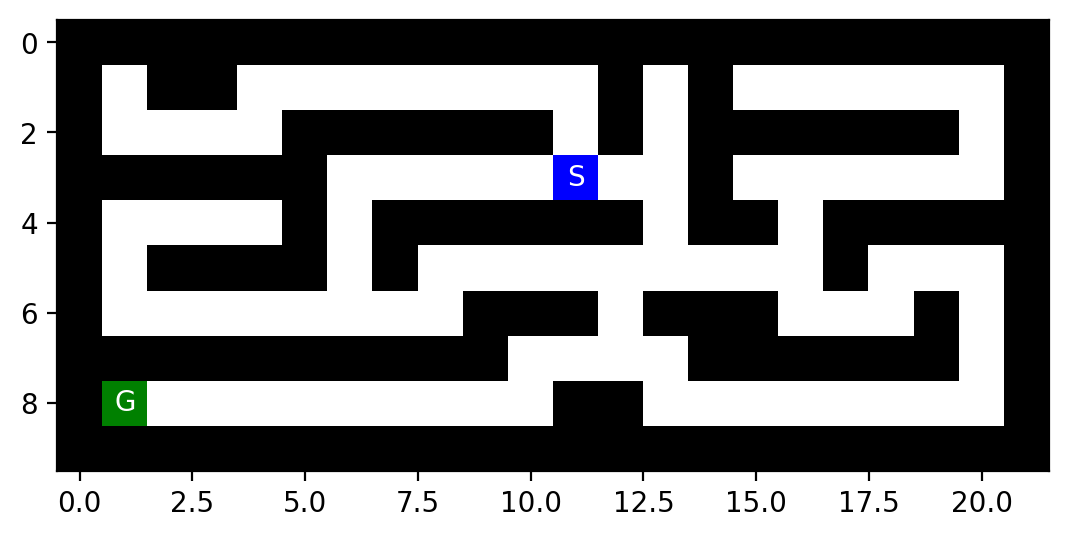

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [ ]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [ ]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /content/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [6]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
2. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

In [5]:
import maze_helper as mh

class Problem:
    def __init__(self, maze, start, goal):
        self.maze = maze
        self.start = mh.find_pos(maze, start) # tuple position of 'S'
        self.goal = mh.find_pos(maze, goal) # tuple position of 'G'
        self.tracker = PerformanceTracker() # an instance of performance trakcer for each problem

    def is_goal(self, state): # checks if the surrent state is the goal
        return state == self.goal

    def is_valid(self, state): # checks if the position is not an obsitckle and is within bounds
        x, y = state
        return self.maze[x][y] != 'X' #0 <= x < len(self.maze) and 0 <= y < len(self.maze[0]) <-- are there mazes without x walls?

    def actions(self, state): # returns the list of valid actions
        x, y = state
        possible_actions = []
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)] # right, left, down, up

        for dx, dy in directions:
            if self.is_valid((x + dx, y + dy)):
                possible_actions.append((dx, dy))
        return possible_actions

    def transition(self, state, action): #transition model
        x, y = state
        dx, dy = action
        return (x + dx, y + dy) #returns new position

In [460]:
# Separate class for performance tracking:
class PerformanceTracker:
    def __init__(self):
        self.reset() # resets the values after each run

    # Reset for each method:
    def reset(self):
        self.path_cost = 0
        self.nodes_expanded = 0
        self.max_tree_depth = 0
        self.max_nodes_in_memory = 0
        self.max_frontier_size = 0

    # Method to run the method for specific problem and print the metrics
    def track(self, problem, search_method):
        self.reset()
        result = search_method(problem, self)  # Pass tracker into the method
        #self.print_metrics()
        return {"Path cost": self.path_cost,
                "Nodes expanded": self.nodes_expanded,
                "Max tree depth": self.max_tree_depth,
                "Max nodes in memory:": self.max_nodes_in_memory,
                "Max frontier size": self.max_frontier_size
                }

    def update_path_cost(self, cost):
        self.path_cost = cost

    def increment_nodes_expanded(self):
        self.nodes_expanded += 1

    def update_max_tree_depth(self, depth):
        self.max_tree_depth = max(self.max_tree_depth, depth)

    def update_max_nodes_in_memory(self, count):
        self.max_nodes_in_memory = max(self.max_nodes_in_memory, count)

    def update_max_frontier_size(self, size):
        self.max_frontier_size = max(self.max_frontier_size, size)

    def print_metrics(self):
        print("Path cost:", self.path_cost)
        print("Nodes expanded:", self.nodes_expanded)
        print("Max tree depth:", self.max_tree_depth)
        print("Max nodes in memory:", self.max_nodes_in_memory)
        print("Max frontier size:", self.max_frontier_size)


Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

In [349]:
# 1. DFS: using Depth-Limited-Search

# Helper method to detect cycles:
def is_cycle(node): # returns true if the current node appears in the ancestors
    anc = node.parent

    while anc: # while not root
        if anc.pos == node.pos:
            return True #cycle
        anc = anc.parent
    return False

#Iterative-Deeeping-Search:
def DFS(problem, tracker=None): # returns the position of the goal

    # Depth-Limited-Search:
    def DLS(problem,limit):
        frontier = [] # stack
        frontier.append(Node(problem.start, None, None, 0)) # push the frontier on stack
        result = "failure"
        visited = 0

        if tracker: tracker.update_max_frontier_size(len(frontier))

        while frontier: # while not empty
            node = frontier.pop()

            if tracker:
                tracker.update_max_tree_depth(node.cost)
                tracker.update_max_nodes_in_memory(len(frontier) + visited)

            if problem.is_goal(node.pos):
                if tracker: tracker.update_path_cost(node.cost)
                return node.pos  # goal found!

            if node.cost > limit:
                result = "cutoff"  # depth limit reached => cuttoff
            # if no cycles:
            elif not is_cycle(node): # if the node not visited:
                visited +=1
                for child in expand(problem, node):
                    frontier.append(child)
                    if tracker: tracker.update_max_frontier_size(len(frontier))
        return result

    # Helper methods:
    def expand(problem, node):
        if tracker: tracker.increment_nodes_expanded()
        children = []
        actions = problem.actions(node.pos) # get the valid actions list

        for action in actions:
            new_pos = problem.transition(node.pos, action) # applying action
            child_node = Node(new_pos, node, action, node.cost + 1) # TODO we just increment the cost by 1, yeah?
            children.append(child_node) # add to the list

        return children

    depth = 0
    while True:
        result = DLS(problem, depth)
        if result != "cutoff":
            return result # reuturn node.pos
        depth += 1


In [369]:
# DFS with 'reached' for cycles detection:

def DFS_with_reached(problem, tracker=None):
    frontier = [] # stack
    reached = {problem.start}

    start_node = Node(problem.start, None, None, 0)
    frontier.append(start_node)

    visited = 0
    if tracker:
        tracker.update_max_frontier_size(len(frontier))

    while frontier:
        node = frontier.pop()

        if tracker:
            tracker.update_max_tree_depth(node.cost)
            tracker.update_max_nodes_in_memory(len(frontier) + visited)

        if problem.is_goal(node.pos):
            if tracker:
                tracker.update_path_cost(node.cost)
            return node.pos  # goal found!

        visited += 1
        for child in expand(problem, node):
            # Check if child node is in reached:
            if child.pos not in reached:
                reached.add(child.pos)
                frontier.append(child)
                if tracker:
                    tracker.update_max_frontier_size(len(frontier))

    return "failure"

# Helper method for expansion:
def expand(problem, node):
    if tracker: tracker.increment_nodes_expanded()

    children = []
    actions = problem.actions(node.pos)

    for action in actions:
        new_pos = problem.transition(node.pos, action)
        child_node = Node(new_pos, node, action, node.cost + 1)
        children.append(child_node)

    return children

In [49]:
from collections import deque

# 2. BFS:
def BFS(problem, tracker=None):

    # Helper methods:
    def expand(problem, node):
        children = []
        actions = problem.actions(node.pos) # get the valid actions list

        for action in actions:
            new_pos = problem.transition(node.pos, action) # applying action
            child_node = Node(new_pos, node, action, node.cost + 1) # TODO we just increment the cost by 1, yeah?
            children.append(child_node) # add to the list

        return children

    initial = Node(problem.start, None, None, 0)
    frontier = deque() # FIFO queue
    reached = {initial.pos} # reached set
    frontier.appendleft(initial)
    if tracker: tracker.update_max_frontier_size(len(frontier))

    if problem.is_goal(initial.pos):
        if tracker:
            tracker.increment_nodes_expanded()
            tracker.update_max_tree_depth(initial.cost)
            tracker.update_max_nodes_in_memory(1)
            tracker.update_max_frontier_size(1)
        return initial.pos

    while frontier:
        node = frontier.pop()

        if tracker:
            tracker.increment_nodes_expanded()
            tracker.update_max_tree_depth(node.cost)
            tracker.update_max_nodes_in_memory(len(frontier) + len(reached))  # frontier + reached

        for child in expand(problem, node):
            if problem.is_goal(child.pos):
                if tracker: tracker.update_path_cost(child.cost)
                return child.pos

            if child.pos not in reached:
                reached.add(child.pos)
                frontier.appendleft(child)
                if tracker: tracker.update_max_frontier_size(len(frontier))

    return "failure"


How does BFS and DFS deal with loops (cycles)?

In [ ]:
# BFS keeps track of reached nodes and DFS has is_cycle() method that checks for the cycles exploring the ancestors of the current node.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

In [ ]:
# DFS is not complete as it enters infinite loop when the iterative deeping search is used bc
# it checks for cycles only in limited ancestors of the current node and doesnt account for all the cycles.

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).


In [42]:
import heapq as pq

# Evaluation function:
def evaluation_f(pos, goal): # Manhattan distance
    x1, y1 = pos
    x2, y2 = goal
    return abs(x2 - x1) + abs(y2 - y1)

# 3. Greedy-Best-First Search:

# Greedy-BFS:
def GBFS(problem, tracker=None):

    # Helper methods:
    def expand(problem, node):
        if tracker: tracker.increment_nodes_expanded()
        children = []
        actions = problem.actions(node.pos) # get the valid actions list

        for action in actions:
            new_pos = problem.transition(node.pos, action) # applying action
            child_node = Node(new_pos, node, action, node.cost + 1) # TODO we just increment the cost by 1, yeah?
            children.append(child_node) # add to the list

        return children

    # Best-First-Search:
    def BestFS(problem, h):
        initial = Node(problem.start, None, None, 0)

        if problem.is_goal(initial.pos):
            return initial.pos

        frontier = [] # Priority Queue
        reached = {initial.pos} # reached set with costs
        pq.heappush(frontier, (h(initial.pos), id(initial), initial)) # push the initial node to priority queue
        if tracker: tracker.update_max_frontier_size(len(frontier))

        while frontier:
            _, _, node = pq.heappop(frontier)

            if tracker:
                tracker.update_max_tree_depth(node.cost)
                tracker.update_max_nodes_in_memory(len(frontier) + len(reached))

            for child in expand(problem, node):
                if problem.is_goal(child.pos):
                    if tracker: tracker.update_path_cost(child.cost)
                    return child.pos
                if child.pos not in reached:
                    reached.add(child.pos)
                    pq.heappush(frontier, (h(child.pos), id(child), child))
                    if tracker: tracker.update_max_frontier_size(len(frontier))
        return "failure"
    # return:
    return BestFS(problem, lambda pos: evaluation_f(pos, problem.goal))


In [305]:
import heapq as pq

# 4. A Star Search: now for the cost function we use not only heuristic, but also the path cost to reach the current node
def A_star(problem, tracker=None):

    # Helper methods:
    def expand(problem, node):
        if tracker: tracker.increment_nodes_expanded()
        children = []
        actions = problem.actions(node.pos) # get the valid actions list
        for action in actions:
            new_pos = problem.transition(node.pos, action) # applying action
            child_node = Node(new_pos, node, action, node.cost + 1) # TODO we just increment the cost by 1, yeah?
            children.append(child_node) # add to the list

        return children

    def BestFS_f(problem, h): # h --> manhattan distance
        initial = Node(problem.start, None, None, 0)
        if problem.is_goal(initial.pos):
            if tracker: tracker.update_path_cost(initial.cost)
            return initial.pos
        c = 1 # for priority queue handling of the same path_cost values
        frontier = [] # Priority Queue
        reached = {initial.pos: initial.cost} # reached set with costs
        # Now, we also add path cost:
        pq.heappush(frontier, (h(initial.pos) + initial.cost, c, initial)) # push the initial node to priority queue
        if tracker: tracker.update_max_frontier_size(len(frontier))

        while frontier:
            _, _, node = pq.heappop(frontier)

            if tracker:
                tracker.update_max_tree_depth(node.cost)
                tracker.update_max_nodes_in_memory(len(frontier) + len(reached))

            for child in expand(problem, node):
                if problem.is_goal(child.pos):
                    if tracker: tracker.update_path_cost(child.cost)
                    return child.pos

                # If not reached yet OR if the stored cost is more than current:
                if child.pos not in reached or (node.cost + 1) < reached[child.pos]:
                    reached[child.pos] = node.cost + 1 # store the cost
                    pq.heappush(frontier, (h(child.pos) + node.cost + 1, c, child))
                    c+=1
                    if tracker: tracker.update_max_frontier_size(len(frontier))

        return "failure"

    return BestFS_f(problem, lambda pos: evaluation_f(pos, problem.goal))


Are your implementations complete and optimal? What is the time and space complexity?

In [487]:
# Discussion:

# Both implementations, A_star and GBFS are complete.
# The time complexity for both is O(b^d), where b is the branhcing factor and d is the depht of the solution.
# Space complexity is also O(b^d) bc we store all nodes in memory.

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [456]:
# Performance report:
def report(problem, tracker):
    return {
      "DFS":
      tracker.track(problem, DFS_with_reached),
      "BFS":
      tracker.track(problem, BFS),
      "GBFS":
      tracker.track(problem, GBFS),
      "A_star":
      tracker.track(problem, A_star),
    }

In [109]:
import maze_helper as mh

In [461]:
final_results = [] # for each maze

In [463]:
# 1. SMALL MAZE:

with open("small_maze.txt", "r") as f:
    maze_str = f.read()
parsed_maze = mh.parse_maze(maze_str)

small_maze = Problem(parsed_maze, 'S', 'G')
tracker = PerformanceTracker()
final_results.append(("small_maze", report(small_maze, tracker)))
#print(final_results)

In [464]:
# 2. MEDIUM MAZE:

with open("medium_maze.txt", "r") as f:
    maze_str = f.read()
parsed_maze = mh.parse_maze(maze_str)

medium_maze = Problem(parsed_maze, 'S', 'G')
tracker = PerformanceTracker()

#report(medium_maze, tracker)
final_results.append(("medium_maze", report(small_maze, tracker)))

In [465]:
# 3. LARGE MAZE:

with open("L_maze.txt", "r") as f:
    maze_str = f.read()
parsed_maze = mh.parse_maze(maze_str)

large_maze = Problem(parsed_maze, 'S', 'G')
tracker = PerformanceTracker()

#report(large_maze, tracker)
final_results.append(("large_maze", report(small_maze, tracker)))

In [466]:
# 4. OPEN MAZE:

with open("open_maze.txt", "r") as f:
    maze_str = f.read()
parsed_maze = mh.parse_maze(maze_str)

open_maze = Problem(parsed_maze, 'S', 'G')
tracker = PerformanceTracker()
print("\n1. DFS:\n")
print("Failed to avoid an infinite loop due to \nopen spaces, but implemented a DFS with 'visited' tracking to avoid cycles")

final_results.append(("open_maze", report(small_maze, tracker)))


1. DFS:

Failed to avoid an infinite loop due to 
open spaces, but implemented a DFS with 'visited' tracking to avoid cycles


In [467]:
# 5. WALL MAZE:

with open("wall_maze.txt", "r") as f:
    maze_str = f.read()
parsed_maze = mh.parse_maze(maze_str)

wall_maze = Problem(parsed_maze, 'S', 'G')
#report(wall_maze, tracker)
final_results.append(("wall_maze", report(small_maze, tracker)))

In [468]:
# 6. LOOPS MAZE:

with open("loops_maze.txt", "r") as f:
    maze_str = f.read()
parsed_maze = mh.parse_maze(maze_str)

loops_maze = Problem(parsed_maze, 'S', 'G')
#report(loops_maze, tracker)
final_results.append(("loops_maze", report(small_maze, tracker)))

In [469]:
# 7. EMPTY MAZE:

with open("empty_maze.txt", "r") as f:
    maze_str = f.read()
parsed_maze = mh.parse_maze(maze_str)

empty_maze = Problem(parsed_maze, 'S', 'G')
#report(empty_maze, tracker)
final_results.append(("empty_maze", report(small_maze, tracker)))

In [470]:
# 8. EMPTY MAZE 2:

with open("empty_2_maze.txt", "r") as f:
    maze_str = f.read()
parsed_maze = mh.parse_maze(maze_str)

empty_maze_2 = Problem(parsed_maze, 'S', 'G')
#report(empty_maze_2, tracker)
final_results.append(("empty_maze_2", report(small_maze, tracker)))

In [471]:
print(final_results)

[('small_maze', {'DFS': {'Path cost': 29, 'Nodes expanded': 53, 'Max tree depth': 29, 'Max nodes in memory:': 56, 'Max frontier size': 4}, 'BFS': {'Path cost': 19, 'Nodes expanded': 90, 'Max tree depth': 18, 'Max nodes in memory:': 94, 'Max frontier size': 9}, 'GBFS': {'Path cost': 29, 'Nodes expanded': 39, 'Max tree depth': 28, 'Max nodes in memory:': 47, 'Max frontier size': 5}, 'A_star': {'Path cost': 19, 'Nodes expanded': 53, 'Max tree depth': 18, 'Max nodes in memory:': 64, 'Max frontier size': 8}}), ('small_maze', {'DFS': {'Path cost': 29, 'Nodes expanded': 53, 'Max tree depth': 29, 'Max nodes in memory:': 56, 'Max frontier size': 4}, 'BFS': {'Path cost': 19, 'Nodes expanded': 90, 'Max tree depth': 18, 'Max nodes in memory:': 94, 'Max frontier size': 9}, 'GBFS': {'Path cost': 29, 'Nodes expanded': 39, 'Max tree depth': 28, 'Max nodes in memory:': 47, 'Max frontier size': 5}, 'A_star': {'Path cost': 19, 'Nodes expanded': 53, 'Max tree depth': 18, 'Max nodes in memory:': 64, 'Max f



1. __Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| DFS       | 19        |    920          |         19     |           119    |             16      |
| BFS       |  19       |   90          |      18        |        94       |        9           |
| GBS       |  29       |        39      |       28       |           47    |          5         |
| A*        |  19       |        53      |        18      |          64     |       8            |
| DFS_2       |  29       |        53      |        29      |          56     |       4            |

2. __Medium Maze__

| algorithm            | path cost | # of nodes expanded | max tree depth  | max # of nodes in memory | max frontier size |
|----------------------|-----------|---------------------|-----------------|--------------------------|-------------------|
| DFS                  | 68        | 15429               | 68              | 802                      | 50                |
| BFS                  | 68        | 266                 | 67              | 272                      | 8                 |
| GBS                 | 74        | 78                  | 73              | 84                       | 4                 |
| A*                   | 68        | 222                 | 67              | 233                      | 8                 |
| DFS_2 | 162   | 254                 | 162             | 264                      | 11                |

3. __Large Maze__

| algorithm            | path cost | # of nodes expanded | max tree depth  | max # of nodes in memory | max frontier size |
|----------------------|-----------|---------------------|-----------------|--------------------------|-------------------|
| DFS                  | 14        | 535220              | 14              | 233125                   | 35                |
| BFS                  | 14        | 133                 | 13              | 145                      | 19                |
| GBS                 | 14        | 14                  | 13              | 52                       | 21                |
| A*                   | 14        | 41                  | 13              | 83                       | 22                |
| DFS_2 | 48   | 123                 | 82              | 157                      | 63                |


4. __Open Maze__


| algorithm            | path cost | # of nodes expanded | max tree depth  | max # of nodes in memory | max frontier size |
|----------------------|-----------|---------------------|-----------------|--------------------------|-------------------|
| DFS                  | N/A |           N/A          |               N/A      |             N/A             |      N/A             |
| BFS                  | 54        | 679                 | 53              | 688                      | 23                |
| GBS                 | 66        | 83                  | 65              | 225                      | 72                |
| A*                   | 54        | 534                 | 53              | 575                      | 23                |
| DFS_2 | 226   | 226                 | 226             | 421                      | 196               |


5. __Wall Maze__

| algorithm            | path cost | # of nodes expanded | max tree depth  | max # of nodes in memory | max frontier size |
|----------------------|-----------|---------------------|-----------------|--------------------------|-------------------|
| DFS                  | 14        | 125385              | 14              | 68298                    | 35                |
| BFS                  | 14        | 85                  | 13              | 91                       | 11                |
| GBS                 | 20        | 21                  | 19              | 65                       | 23                |
| A*                   | 14        | 55                  | 13              | 113                      | 30                |
| DFS_2 | 20   | 69                  | 42              | 91                       | 39                |



6. __Loops Maze__

| algorithm            | path cost | # of nodes expanded | max tree depth  | max # of nodes in memory | max frontier size |
|----------------------|-----------|---------------------|-----------------|--------------------------|-------------------|
| DFS                  | 23        | 78677               | 23              | 18080                    | 38                |
| BFS                  | 23        | 70                  | 22              | 73                       | 7                 |
| GBS                 | 23        | 51                  | 22              | 69                       | 10                |
| A*                   | 23        | 58                  | 22              | 66                       | 6                 |
| DFS_2 | 37   | 50                  | 38              | 61                       | 13                |

7. __Empty Maze__

| algorithm            | path cost | # of nodes expanded | max tree depth  | max # of nodes in memory | max frontier size |
|----------------------|-----------|---------------------|-----------------|--------------------------|-------------------|
| DFS                  | 14        | 204498              | 14              | 123014                   | 36                |
| BFS                  | 14        | 92                  | 13              | 98                       | 12                |
| GBS                 | 14        | 14                  | 13              | 54                       | 21                |
| A*                   | 14        | 62                  | 13              | 120                      | 30                |
| DFS_2 | 34   | 62                  | 52              | 98                       | 45                |


8. __Empty Maze_2__

| algorithm            | path cost | # of nodes expanded | max tree depth  | max # of nodes in memory | max frontier size |
|----------------------|-----------|---------------------|-----------------|--------------------------|-------------------|
| DFS                  | 14        | 240352              | 14              | 123021                   | 34                |
| BFS                  | 14        | 92                  | 13              | 98                       | 12                |
| GBS                 | 14        | 14                  | 13              | 62                       | 26                |
| A*                   | 14        | 62                  | 13              | 120                      | 30                |
| DFS_2 | 34   | 46                  | 45              | 84                       | 40                |


Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

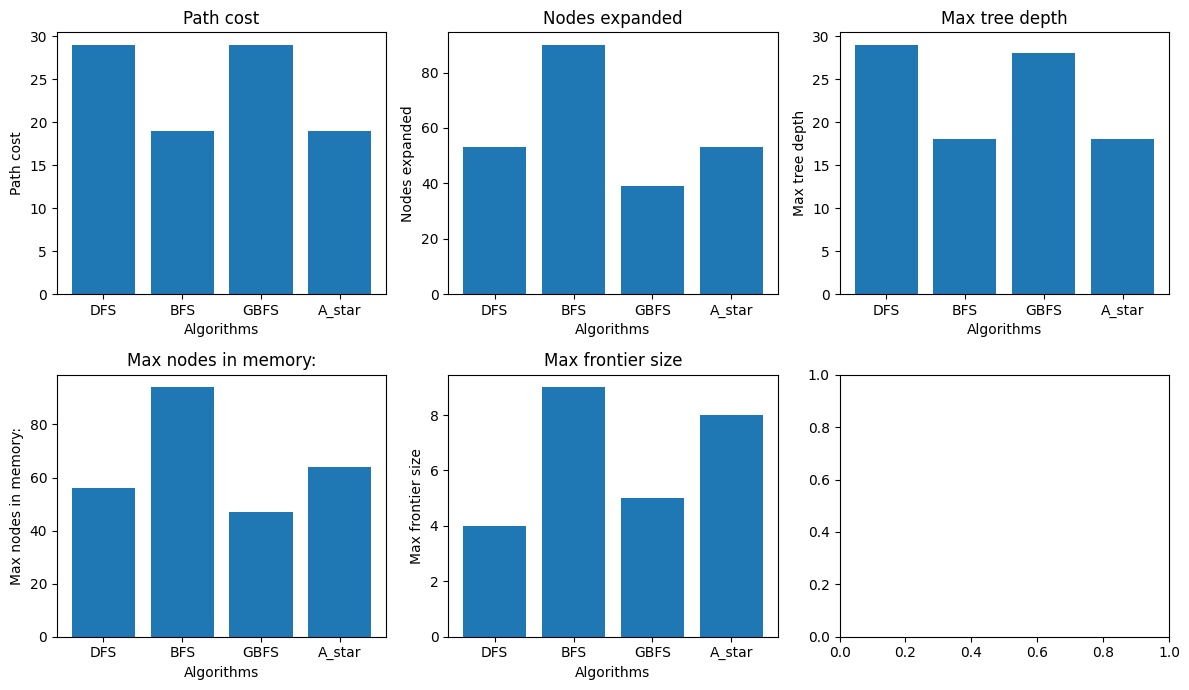

In [486]:
import matplotlib.pyplot as plt
import numpy as np

# to store metrics:
metric_data = {
    "Path cost": [],
    "Nodes expanded": [],
    "Max tree depth": [],
    "Max nodes in memory:": [], # initially mad a typo in the tracker.track() method
    "Max frontier size": []
}
for maze, algorithms in final_results:
    for algorithm, metrics in algorithms.items():
        for metric, value in metrics.items():
            metric_data[metric].append(value)

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()

for i, (metric, values) in enumerate(metric_data.items()):
    ax = axes[i]
    avg_values = np.mean(np.array(values).reshape(len(final_results), -1), axis=0)
    ax.bar(range(len(avg_values)), avg_values)
    ax.set_title(f'{metric}')
    ax.set_xlabel('Algorithms')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(avg_values)))
    ax.set_xticklabels(['DFS', 'BFS', 'GBFS', 'A_star'])

plt.tight_layout()
plt.show()

Discuss the most important lessons you have learned from implementing the different search strategies.

In [ ]:
# Add discussion

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.